In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/train")[0])
# Any results you write to the current directory are saved as output.

53cd84dd8190c3b61869e5c6e364ef71618d0803.tif


In [2]:
!pip install efficientnet_pytorch
!pip install torchsummary
from efficientnet_pytorch import EfficientNet
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
import torch.optim as optim
import copy
import os
import torch
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/opt/conda/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
train_csv = pd.read_csv('../input/train_labels.csv')
train_csv.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


In [4]:
classes = train_csv['label'].unique()
encoder = {0:'negative',1:'positive'}

In [42]:
from sklearn.model_selection import train_test_split
train_df,val_df = train_test_split(train_csv,test_size = 0.2)

In [5]:
class cancer_dataset(Dataset):
  def __init__(self,image_dir,train_csv,transform = None):
    self.img_dir = image_dir
    self.transform = transform
    self.id = train_csv.iloc[:,0]
    self.classes =  train_csv.iloc[:,1]
  def __len__(self):
    return len(self.id)
  def __getitem__(self,idx):
    img_name = os.path.join(self.img_dir, self.id[idx]+'.tif')
    image = cv2.imread(img_name)
    if self.transform:
        image = self.transform(image)
    label = self.classes[idx]
    return image,label

In [15]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
from tqdm.autonotebook import tqdm
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
#data loader

def data_loader(train_data,encoder,test_data = None,valid_data = None , valid_size = None,test_size = None , batch_size = 32,inv_normalize = None):
    #class_plot(train_data,encoder,inv_normalize)
    if(test_data == None and valid_size == None and valid_data == None and test_size == None):
        train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
        dataloaders = {'train':train_loader}
        return dataloaders
    if(test_data !=None and valid_size==None and valid_data == None):
        test_loader = DataLoader(test_data, batch_size= batch_size,shuffle = True)
        train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)

        dataloaders = {'train':train_loader,'test':test_loader}

    if(test_data == None and valid_size!=None and valid_data == None):
        if(test_size==None):
            data_len = len(train_data)
            indices = list(range(data_len))
            np.random.shuffle(indices)
            split1 = int(np.floor(valid_size * data_len))
            valid_idx , train_idx = indices[:split1], indices[split1:]
            valid_sampler = SubsetRandomSampler(valid_idx)
            train_sampler = SubsetRandomSampler(train_idx)
            valid_loader = DataLoader(train_data, batch_size= batch_size, sampler=valid_sampler)
            train_loader =  DataLoader(train_data, batch_size = batch_size , sampler=valid_sampler)
            dataloaders = {'train':train_loader,'val':valid_loader}
            return dataloaders
        if(test_size !=None):
            data_len = len(train_data)
            indices = list(range(data_len))
            np.random.shuffle(indices)
            split1 = int(np.floor(valid_size * data_len))
            split2 = int(np.floor(test_size * data_len))
            valid_idx , test_idx,train_idx = indices[:split1], indices[split1:split1+split2],indices[split1+split2:]
            valid_sampler = SubsetRandomSampler(valid_idx)
            test_sampler = SubsetRandomSampler(test_idx)
            train_sampler = SubsetRandomSampler(train_idx)
            valid_loader = DataLoader(test_data, batch_size= batch_size, sampler=valid_sampler)
            test_loader = DataLoader(test_data, batch_size= batch_size, sampler=test_sampler)
            train_loader =  DataLoader(train_data, batch_size = batch_size , sampler=valid_sampler)
            dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}
            return dataloaders
    if(test_data != None and valid_size!=None):
        data_len = len(test_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx , test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        test_sampler = SubsetRandomSampler(test_idx)
        valid_loader = DataLoader(test_data, batch_size= batch_size, sampler=valid_sampler)
        test_loader = DataLoader(test_data, batch_size= batch_size, sampler=test_sampler)
        train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)

        dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}
        return dataloaders
    if(test_data!=None and valid_data !=None):
        valid_loader = DataLoader(valid_data, batch_size= batch_size,shuffle  = True)
        test_loader = DataLoader(test_data, batch_size= batch_size,shuffle = True)
        train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)

        dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}
        return dataloaders
def normalization_parameter(dataloader):
    mean = 0.
    std = 0.
    nb_samples = len(dataloader.dataset)
    for data,_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean,std

In [7]:
im_size = 32
batch_size = 128

from torchvision import transforms
from torch.utils.data import DataLoader

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor()])
train_data = cancer_dataset('../input/train',train_csv,transform = train_transforms)
train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)

In [8]:
import cv2
mean,std = normalization_parameter(train_loader)

In [38]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.transforms.RandomRotation(10),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

#inverse normalization for image plot

inv_normalize =  transforms.Normalize(
    mean=-1*np.divide(mean,std),
    std=1/std
)

In [26]:
train_data = cancer_dataset('../input/train',train_df,transform = train_transforms)
val_data = cancer_dataset('../input/train',test_df,transform = test_transforms)

dataloaders =  data_loader(train_data,encoder = encoder,valid_size = 0.2, batch_size = batch_size)

In [39]:
from efficientnet_pytorch import EfficientNet
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
import torch.optim as optim
import copy
import os
import torch
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

class classifie(nn.Module):
    def __init__(self,n_classes ):
        super(classifie, self).__init__()
        self.cnn_arch = EfficientNet.from_pretrained('efficientnet-b0')
        self.linear1 = nn.Linear(1000,256)
        self.relu = nn.LeakyReLU()
        self.linear2 = nn.Linear(256,n_classes)
        #self.softmax = nn.Softmax(dim=1)
        self.bn = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.75)
        
    def forward(self, input):
        am = self.cnn_arch(input)
        x = self.dropout(self.bn(self.relu(self.linear1(am))))
        x = self.linear2(x)
        return x

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = classifie(n_classes = 2).to(device)

Loaded pretrained weights for efficientnet-b0


In [20]:
from __future__ import print_function, with_statement, division
import copy
import os
import torch
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt


class LRFinder(object):
    """Learning rate range test.
    The learning rate range test increases the learning rate in a pre-training run
    between two boundaries in a linear or exponential manner. It provides valuable
    information on how well the network can be trained over a range of learning rates
    and what is the optimal learning rate.
    Arguments:
        model (torch.nn.Module): wrapped model.
        optimizer (torch.optim.Optimizer): wrapped optimizer where the defined learning
            is assumed to be the lower boundary of the range test.
        criterion (torch.nn.Module): wrapped loss function.
        device (str or torch.device, optional): a string ("cpu" or "cuda") with an
            optional ordinal for the device type (e.g. "cuda:X", where is the ordinal).
            Alternatively, can be an object representing the device on which the
            computation will take place. Default: None, uses the same device as `model`.
        memory_cache (boolean): if this flag is set to True, `state_dict` of model and
            optimizer will be cached in memory. Otherwise, they will be saved to files
            under the `cache_dir`.
        cache_dir (string): path for storing temporary files. If no path is specified,
            system-wide temporary directory is used.
            Notice that this parameter will be ignored if `memory_cache` is True.
    Example:
        >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
        >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
    Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    fastai/lr_find: https://github.com/fastai/fastai
    """

    def __init__(self, model, optimizer, criterion, device=None, memory_cache=True, cache_dir=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.history = {"lr": [], "loss": []}
        self.best_loss = None
        self.memory_cache = memory_cache
        self.cache_dir = cache_dir

        # Save the original state of the model and optimizer so they can be restored if
        # needed
        self.model_device = next(self.model.parameters()).device
        self.state_cacher = StateCacher(memory_cache, cache_dir=cache_dir)
        self.state_cacher.store('model', self.model.state_dict())
        self.state_cacher.store('optimizer', self.optimizer.state_dict())

        # If device is None, use the same as the model
        if device:
            self.device = device
        else:
            self.device = self.model_device

    def reset(self):
        """Restores the model and optimizer to their initial states."""
        self.model.load_state_dict(self.state_cacher.retrieve('model'))
        self.optimizer.load_state_dict(self.state_cacher.retrieve('optimizer'))
        self.model.to(self.model_device)

    def range_test(
        self,
        train_loader,
        val_loader=None,
        end_lr=10,
        num_iter=100,
        step_mode="exp",
        smooth_f=0.05,
        diverge_th=5,
    ):
        """Performs the learning rate range test.
        Arguments:
            train_loader (torch.utils.data.DataLoader): the training set data laoder.
            val_loader (torch.utils.data.DataLoader, optional): if `None` the range test
                will only use the training loss. When given a data loader, the model is
                evaluated after each iteration on that dataset and the evaluation loss
                is used. Note that in this mode the test takes significantly longer but
                generally produces more precise results. Default: None.
            end_lr (float, optional): the maximum learning rate to test. Default: 10.
            num_iter (int, optional): the number of iterations over which the test
                occurs. Default: 100.
            step_mode (str, optional): one of the available learning rate policies,
                linear or exponential ("linear", "exp"). Default: "exp".
            smooth_f (float, optional): the loss smoothing factor within the [0, 1[
                interval. Disabled if set to 0, otherwise the loss is smoothed using
                exponential smoothing. Default: 0.05.
            diverge_th (int, optional): the test is stopped when the loss surpasses the
                threshold:  diverge_th * best_loss. Default: 5.
        """
        # Reset test results
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Move the model to the proper device
        self.model.to(self.device)

        # Initialize the proper learning rate policy
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")

        # Create an iterator to get data batch by batch
        iterator = iter(train_loader)
        for iteration in tqdm(range(num_iter)):
            # Get a new set of inputs and labels
            try:
                inputs, labels = next(iterator)
            except StopIteration:
                iterator = iter(train_loader)
                inputs, labels = next(iterator)

            # Train on batch and retrieve loss
            loss = self._train_batch(inputs, labels)
            if val_loader:
                loss = self._validate(val_loader)

            # Update the learning rate
            lr_schedule.step()
            self.history["lr"].append(lr_schedule.get_lr()[0])

            # Track the best loss and smooth it if smooth_f is specified
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                if loss < self.best_loss:
                    self.best_loss = loss

            # Check if the loss has diverged; if it has, stop the test
            self.history["loss"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")

    def _train_batch(self, inputs, labels):
        # Set model to training mode
        self.model.train()

        # Move data to the correct device
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)

        # Forward pass
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)

        # Backward pass
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def _validate(self, dataloader):
        # Set model to evaluation mode and disable gradient computation
        running_loss = 0
        self.model.eval()
        with torch.no_grad():
            for inputs, labels in dataloader:
                # Move data to the correct device
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Forward pass and loss computation
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

        return running_loss / len(dataloader.dataset)

    def plot(self, skip_start=10, skip_end=5, log_lr=True):
        """Plots the learning rate range test.
        Arguments:
            skip_start (int, optional): number of batches to trim from the start.
                Default: 10.
            skip_end (int, optional): number of batches to trim from the start.
                Default: 5.
            log_lr (bool, optional): True to plot the learning rate in a logarithmic
                scale; otherwise, plotted in a linear scale. Default: True.
        """

        if skip_start < 0:
            raise ValueError("skip_start cannot be negative")
        if skip_end < 0:
            raise ValueError("skip_end cannot be negative")

        # Get the data to plot from the history dictionary. Also, handle skip_end=0
        # properly so the behaviour is the expected
        lrs = self.history["lr"]
        losses = self.history["loss"]
        if skip_end == 0:
            lrs = lrs[skip_start:]
            losses = losses[skip_start:]
        else:
            lrs = lrs[skip_start:-skip_end]
            losses = losses[skip_start:-skip_end]

        # Plot loss as a function of the learning rate
        plt.plot(lrs, losses)
        if log_lr:
            plt.xscale("log")
        plt.xlabel("Learning rate")
        plt.ylabel("Loss")
        plt.show()


class LinearLR(_LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float, optional): the initial learning rate which is the lower
            boundary of the test. Default: 10.
        num_iter (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        last_epoch (int): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]


class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float, optional): the initial learning rate which is the lower
            boundary of the test. Default: 10.
        num_iter (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        last_epoch (int): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class StateCacher(object):
    def __init__(self, in_memory, cache_dir=None):
        self.in_memory = in_memory
        self.cache_dir = cache_dir

        if self.cache_dir is None:
            import tempfile
            self.cache_dir = tempfile.gettempdir()
        else:
            if not os.path.isdir(self.cache_dir):
                raise ValueError('Given `cache_dir` is not a valid directory.')

        self.cached = {}

    def store(self, key, state_dict):
        if self.in_memory:
            self.cached.update({key: copy.deepcopy(state_dict)})
        else:
            fn = os.path.join(self.cache_dir, 'state_{}_{}.pt'.format(key, id(self)))
            self.cached.update({key: fn})
            torch.save(state_dict, fn)

    def retrieve(self, key):
        if key not in self.cached:
            raise KeyError('Target {} was not cached.'.format(key))

        if self.in_memory:
            return self.cached.get(key)
        else:
            fn = self.cached.get(key)
            if not os.path.exists(fn):
                raise RuntimeError('Failed to load state in {}. File does not exist anymore.'.format(fn))
            state_dict = torch.load(fn, map_location=lambda storage, location: storage)
            return state_dict

    def __del__(self):
        """Check whether there are unused cached files existing in `cache_dir` before
        this instance being destroyed."""
        if self.in_memory:
            return

        for k in self.cached:
            if os.path.exists(self.cached[k]):
                os.remove(self.cached[k])

In [21]:
def lr_finder(model,train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(model.parameters(), lr=0.0000001)
    lr_finder = LRFinder(model, optimizer_ft, criterion, device=device)
    lr_finder.range_test(train_loader, end_lr=1, num_iter=1000)
    lr_finder.reset()
    lr_finder.plot()

In [27]:
train_loader = dataloaders['train']

/opt/conda/lib/python3.6/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/opt/conda/lib/python3.6/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


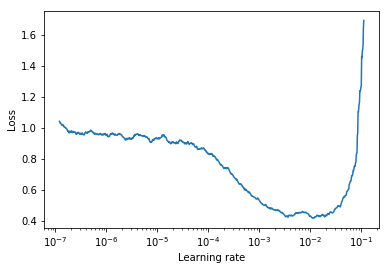

In [28]:
lr_finder(classifier,train_loader)

In [29]:
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from torch.autograd import Variable
import numpy as np
import torch
from torch import nn

def train(model,dataloaders,device,num_epochs,lr,batch_size,patience):
    best_acc = 0.0
    i = 0
    phase1 = dataloaders.keys()
    losses = list()
    criterion = nn.CrossEntropyLoss()
    acc = list()
    for epoch in range(num_epochs):
        print('Epoch:',epoch)
        optimizer = optim.Adam(model.parameters(), lr=lr , weight_decay = 0.001)
        lr = lr*0.9
        for phase in phase1:
            if phase == ' train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            total = 0
            j = 0
            for  batch_idx, (data, target) in enumerate(dataloaders[phase]):
                data, target = Variable(data), Variable(target)
                data = data.type(torch.FloatTensor).to(device)
                target = target.type(torch.LongTensor).to(device)

                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                _, preds = torch.max(output, 1)
                running_corrects = running_corrects + torch.sum(preds == target.data)
                running_loss += loss.item() * data.size(0)
                j = j+1
                if(phase =='train'):
                    loss.backward()
                    optimizer.step()

                if batch_idx % 100 == 0:
                    print('{} Epoch: {}  [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAcc: {:.6f}'.format(phase,epoch, batch_idx * len(data), len(dataloaders[phase].dataset),100. * batch_idx / len(dataloaders[phase])
                                                                                                 , running_loss/(j*batch_size),running_corrects.double()/(j*batch_size)))
            epoch_acc = running_corrects.double()/(len(dataloaders[phase])*batch_size)
            epoch_loss = running_loss/(len(dataloaders[phase])*batch_size)
            if(phase == 'train'):
                losses.append(epoch_loss)
                acc.append(epoch_acc)
        print('{} Accuracy: {}'.format(phase,epoch_acc.item()))
    return losses,acc

def train_model(model,dataloaders,encoder,lr_scheduler = None,inv_normalize = None,num_epochs=10,lr=0.0001,batch_size=8,patience = None,classes = None):
    dataloader_train = {}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    losses = list()
    accuracy = list()
    key = dataloaders.keys()
    perform_test = False
    for phase in key:
        if(phase == 'test'):
            perform_test = True
        else:
            dataloader_train.update([(phase,dataloaders[phase])])
    losses,accuracy = train(model,dataloader_train,device,num_epochs,lr,batch_size,patience)

In [41]:
lr = 0.001
train_model(classifier,dataloaders,encoder,inv_normalize,num_epochs=5,lr = lr,batch_size = batch_size,patience = None,classes = classes)

Epoch: 0


/opt/conda/lib/python3.6/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/opt/conda/lib/python3.6/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)


train Epoch: 0  [0/220025 (0%)]	Loss: 0.695550 	Acc: 0.429688
train Epoch: 0  [12800/220025 (29%)]	Loss: 0.522646 	Acc: 0.752475
train Epoch: 0  [25600/220025 (58%)]	Loss: 0.463744 	Acc: 0.788557
train Epoch: 0  [38400/220025 (87%)]	Loss: 0.441539 	Acc: 0.802455
val Epoch: 0  [0/220025 (0%)]	Loss: 0.311815 	Acc: 0.867188
val Epoch: 0  [12800/220025 (29%)]	Loss: 0.368720 	Acc: 0.834158
val Epoch: 0  [25600/220025 (58%)]	Loss: 0.366278 	Acc: 0.835704
val Epoch: 0  [38400/220025 (87%)]	Loss: 0.367590 	Acc: 0.834925
val Accuracy: 0.8330532340116279
Epoch: 1
train Epoch: 1  [0/220025 (0%)]	Loss: 0.358228 	Acc: 0.835938
train Epoch: 1  [12800/220025 (29%)]	Loss: 0.407007 	Acc: 0.829749
train Epoch: 1  [25600/220025 (58%)]	Loss: 0.382400 	Acc: 0.837531
train Epoch: 1  [38400/220025 (87%)]	Loss: 0.375855 	Acc: 0.840350
val Epoch: 1  [0/220025 (0%)]	Loss: 0.282636 	Acc: 0.875000
val Epoch: 1  [12800/220025 (29%)]	Loss: 0.338151 	Acc: 0.855817
val Epoch: 1  [25600/220025 (58%)]	Loss: 0.338730 	A

KeyboardInterrupt: 